# Comparison with GroundTruth

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import skimage.io
import skimage.color
import skimage.transform
import skimage.morphology

from typing import List, Tuple
from typing import Optional
import numpy
from MODULES.namedtuple import Partition

### Helper functions

In [47]:
def contours_from_labels(labels, thickness: int=1):
    contours = (skimage.morphology.dilation(labels)  != labels)
    for i in range(1,thickness):
        contours = skimage.morphology.binary_dilation(contours)
    return contours

def add_red_contours(image, contours):
    assert image.shape[:2] == contours.shape[:2]
    my_max = numpy.max(image)
    if len(image.shape) == 2:
        image = numpy.repeat(image[..., None], 3, axis=-1)
    assert len(image.shape)== 3 # w,h,ch
    assert image.shape[-1] == 3 # 3 channels
    image[contours, 0] = my_max
    image[contours, 1:] = 0
    return image



def make_list_of_windows(ROI_mask: numpy.ndarray, n: int = 4, crop_size: int = 80):
    delta = 200
    window = list()
    while len(window)<n:
        iw = numpy.random.randint(low=0, high=ROI_mask.shape[0]-crop_size, size=1, dtype=int).item()
        ih = numpy.random.randint(low=0, high=ROI_mask.shape[1]-crop_size, size=1, dtype=int).item()
        if (ROI_mask[iw,ih] == 0) and (ROI_mask[iw+crop_size,ih] == 0) and \
           (ROI_mask[iw,ih+crop_size] == 0) and (ROI_mask[iw+crop_size,ih+crop_size] == 0):
            continue
        else:
            window.append((iw,ih,iw+crop_size,ih+crop_size))
    return window


def plot_comparison(raw_img, labels1, labels2, window: Optional[List[tuple]] = None, figsize: tuple =(24,24)):
    if window is None:
        window = [[0,0,img1.shape[0],img1.shape[1]]]
    
    n = len(window)
    if n>1:
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=2, figsize=figsize)
        
    for row,w in enumerate(window):
        img = raw_img[w[0]:w[2],w[1]:w[3]]
        l1 = labels1[w[0]:w[2],w[1]:w[3]]
        l2 = labels2[w[0]:w[2],w[1]:w[3]]
        c1 = contours_from_labels(l1, thickness=3)
        c2 = contours_from_labels(l2, thickness=3)
        tmp1 = add_red_contours(img, c1)
        tmp2 = add_red_contours(img, c2)
        # print(tmp1.dtype, img.dtype)

        if n>1:
            axs[row,0].imshow(tmp1, aspect='equal')
            axs[row,1].imshow(tmp2, aspect='equal')
        else:
            axs[0].imshow(tmp1, aspect='equal')
            axs[1].imshow(tmp2, aspect='equal')
            

def make_and_save_segmentation(file_name, labels, raw_image):
    assert labels.shape[:2] == raw_image.shape[:2]
    c = contours_from_labels(labels=labels, thickness=3)
    tmp = add_red_contours(image=skimage.img_as_ubyte(raw_image), contours=c)
    print(tmp.shape, tmp.dtype)
    skimage.io.imsave(file_name, tmp)

### Open the files

In [94]:
image_file = "smFISH_stitched_OLEH.tif"
oleh_file = "smFISH-full_result_mask.tif"
luca_file = "segmentation_res800.tiff"
gt_file = "manual_annotation_aligned.tif"

raw_img = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(skimage.io.imread(image_file)))
luca_small = skimage.io.imread(luca_file).astype(numpy.uint16)
oleh_img = skimage.io.imread(oleh_file).astype(numpy.uint16)
gt_img = skimage.io.imread(gt_file).astype(numpy.uint16)


# gt_file_transpose = "segmentation_labels_from_json_transposed.tiff"
#dx=50
#dy=-100
#gt_img = skimage.io.imread(gt_file_transpose).astype(numpy.uint16).T
#gt_shifted = numpy.roll(numpy.roll(gt_img, dx, axis=0), dy, axis=1)[-raw_img.shape[0]:,:raw_img.shape[1]]
#skimage.io.imsave("manual_annotation_aligned.tif", gt_shifted, plugin=None, check_contrast=True)

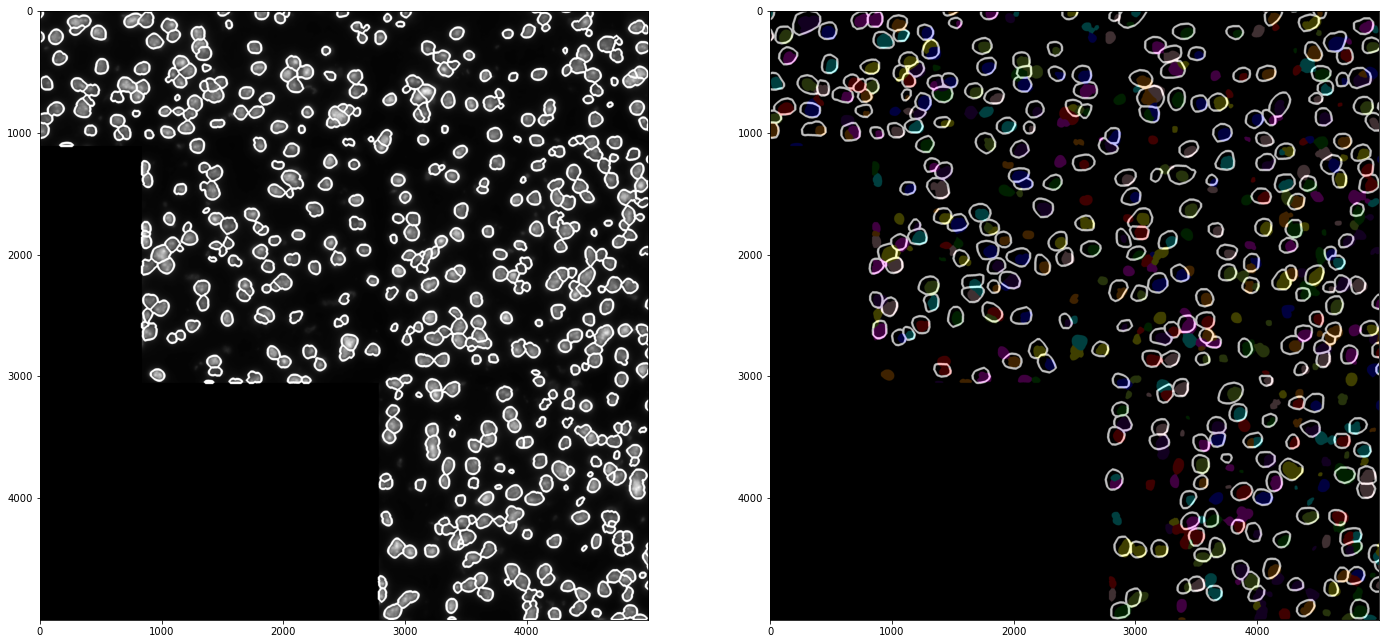

In [98]:
def add_contours(labels, img):
    c = contours_from_labels(labels, thickness=10)
    #return add_red_contours(img, c)
    tmp = numpy.copy(img)
    tmp[c]=numpy.max(img)
    return tmp

fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(add_contours(oleh_img[-5000:,5000:10000], raw_img[-5000:,5000:10000]), cmap='gray')

axes[1].imshow(skimage.color.label2rgb(oleh_img[-5000:,5000:10000],
                                    contours_from_labels(gt_img[-5000:,5000:10000], 10),
                                    alpha=0.25,
                                    bg_label=0))

In [99]:
raw_small = skimage.transform.rescale(raw_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
gt_small = skimage.transform.rescale(gt_img, scale=0.125,
                                     order=0, 
                                     clip=True, preserve_range=True).astype(numpy.uint16)
oleh_small = skimage.transform.rescale(oleh_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
skimage.io.imsave("raw_small.tif", raw_small, plugin=None, check_contrast=True)
skimage.io.imsave("gt_small.tif", gt_small, plugin=None, check_contrast=True)
skimage.io.imsave("oleh_small.tif", oleh_small, plugin=None, check_contrast=True)

<ipython-input-99-a596f5b1b061>:10: UserWarning: raw_small.tif is a low contrast image
  skimage.io.imsave("raw_small.tif", raw_small, plugin=None, check_contrast=True)
<ipython-input-99-a596f5b1b061>:11: UserWarning: gt_small.tif is a low contrast image
  skimage.io.imsave("gt_small.tif", gt_small, plugin=None, check_contrast=True)


In [100]:
raw_medium = skimage.transform.rescale(raw_img, scale=0.25,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
gt_medium = skimage.transform.rescale(gt_img, scale=0.25,
                                     order=0, 
                                     clip=True, preserve_range=True).astype(numpy.uint16)
oleh_medium = skimage.transform.rescale(oleh_img, scale=0.25,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
skimage.io.imsave("raw_medium.tif", raw_medium, plugin=None, check_contrast=True)
skimage.io.imsave("gt_medium.tif", gt_medium, plugin=None, check_contrast=True)
skimage.io.imsave("oleh_medium.tif", oleh_medium, plugin=None, check_contrast=True)

<ipython-input-100-3bf0e141ff53>:10: UserWarning: raw_medium.tif is a low contrast image
  skimage.io.imsave("raw_medium.tif", raw_medium, plugin=None, check_contrast=True)
<ipython-input-100-3bf0e141ff53>:11: UserWarning: gt_medium.tif is a low contrast image
  skimage.io.imsave("gt_medium.tif", gt_medium, plugin=None, check_contrast=True)


In [95]:
print(gt_img.shape, oleh_img.shape)

(21505, 21505) (21505, 21505)


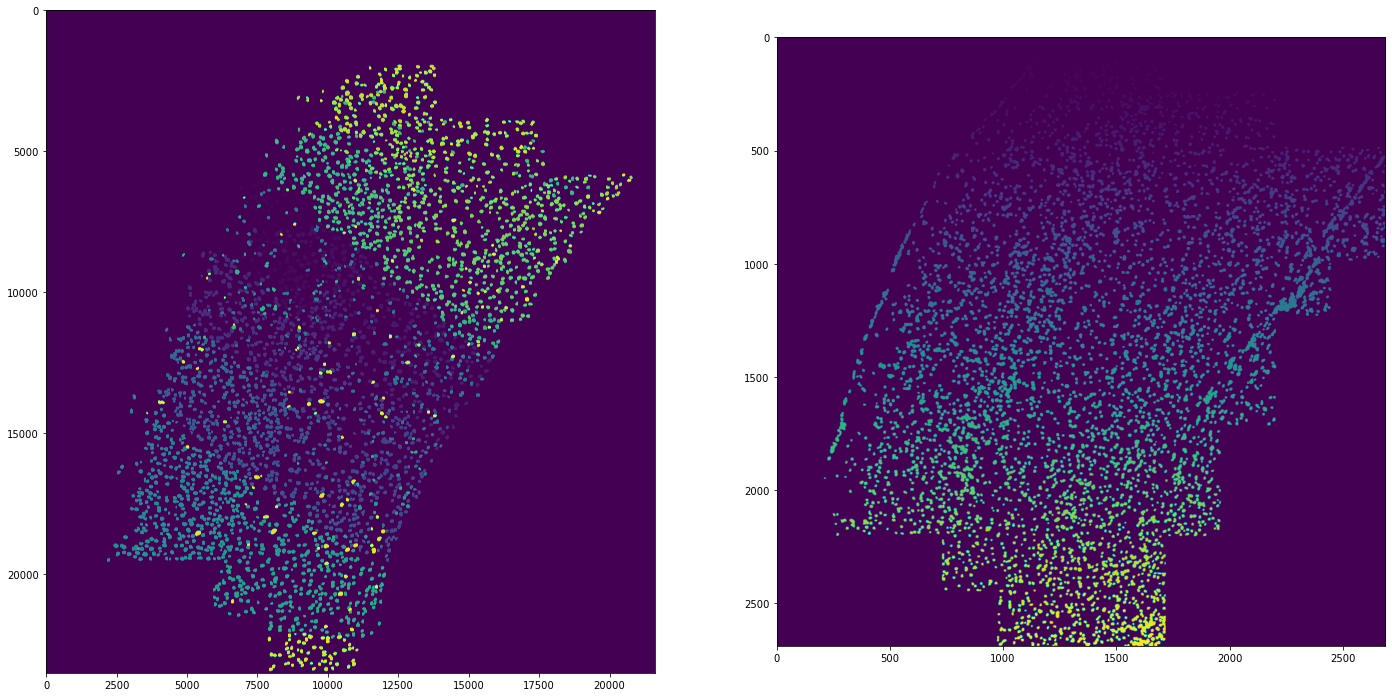

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(gt_img)
axes[1].imshow(luca_img)

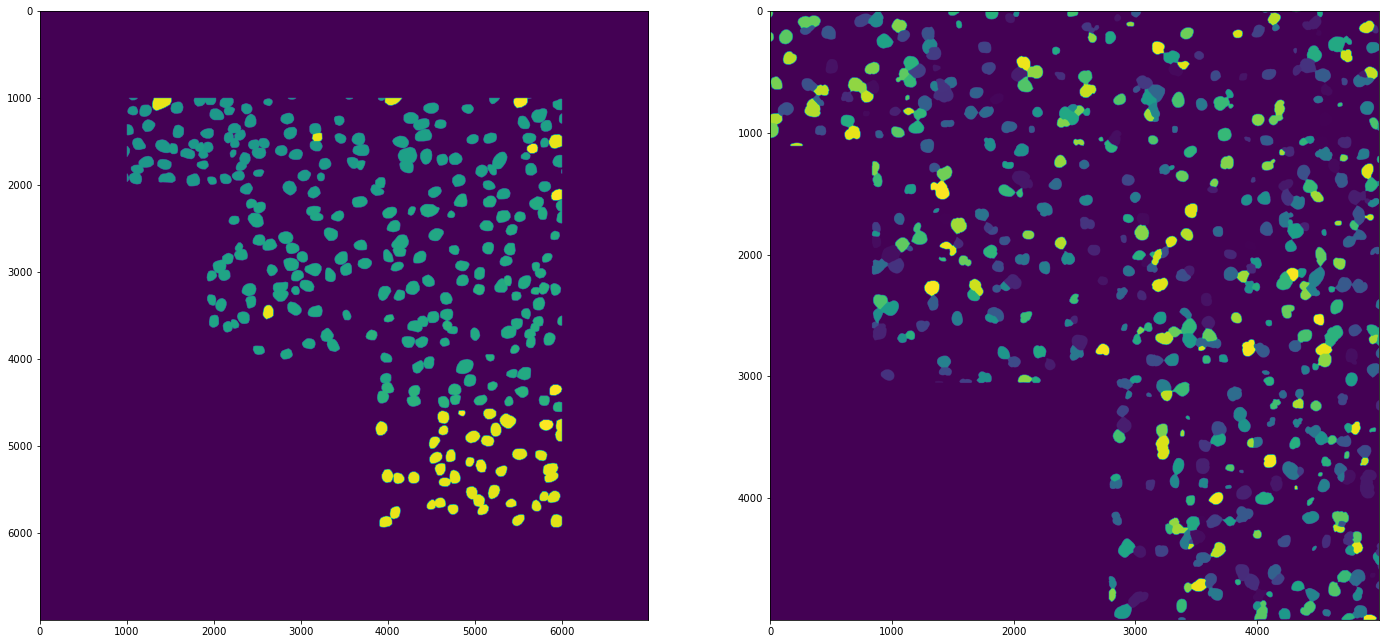

In [79]:
pad=1000
gt = skimage.util.pad(numpy.copy(gt_img[-5000:,5000:10000]), pad, mode='constant', constant_values=0)
oleh = numpy.copy(oleh_img[-5000:,5000:10000])
raw = numpy.copy(raw_img[-5000:,5000:10000])
fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(gt)
axes[1].imshow(oleh)

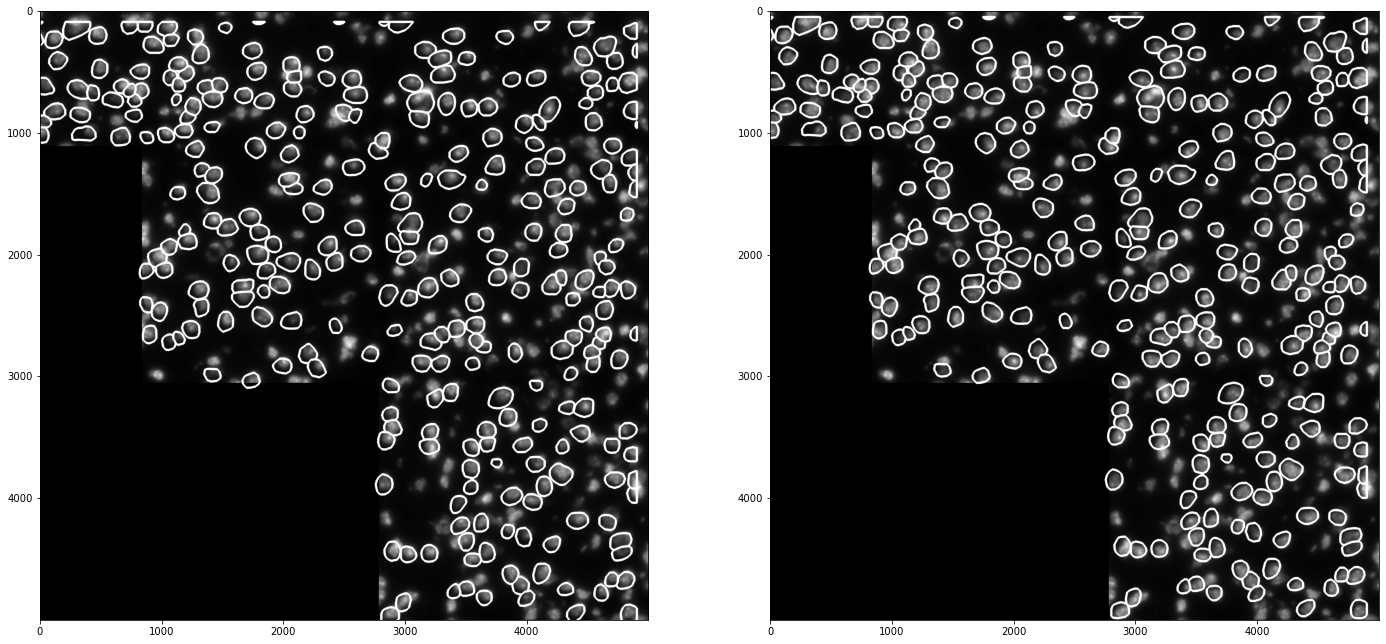

In [83]:
dx=90
dy=-100
aaa = numpy.roll(numpy.roll(gt, dx, axis=0), dy, axis=1)[pad:pad+raw.shape[0],pad:pad+raw.shape[1]]

dx=50
dy=-100
bbb = numpy.roll(numpy.roll(gt, dx, axis=0), dy, axis=1)[pad:pad+raw.shape[0],pad:pad+raw.shape[1]]

def add_contours(labels, img):
    c = contours_from_labels(labels, thickness=10)
    #return add_red_contours(img, c)
    tmp = numpy.copy(img)
    tmp[c]=numpy.max(img)
    return tmp

fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(add_contours(aaa, raw), cmap='gray')
axes[1].imshow(add_contours(bbb, raw), cmap='gray')

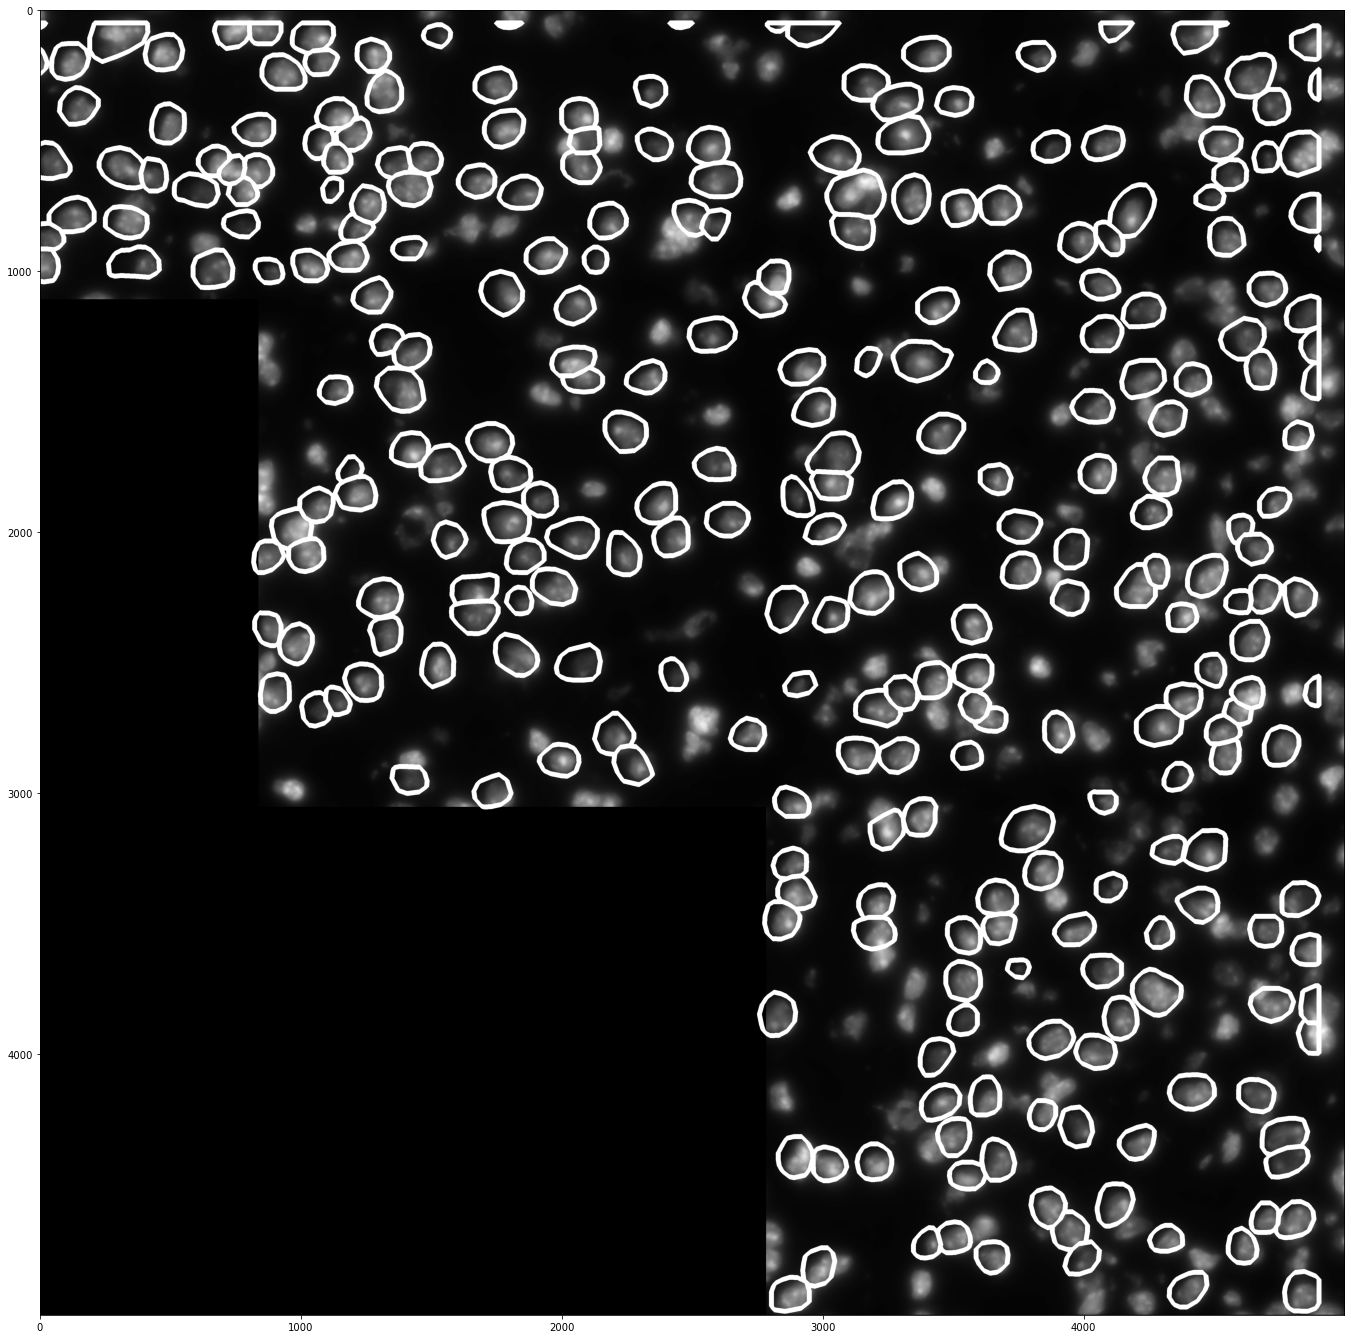

In [87]:
fig, axes = plt.subplots(figsize=(24,24))
axes.imshow(add_contours(bbb, raw), cmap='gray')

<ipython-input-93-66e261622251>:4: UserWarning: manual_annotation_aligned.tif is a low contrast image
  skimage.io.imsave("manual_annotation_aligned.tif", gt_shifted, plugin=None, check_contrast=True)


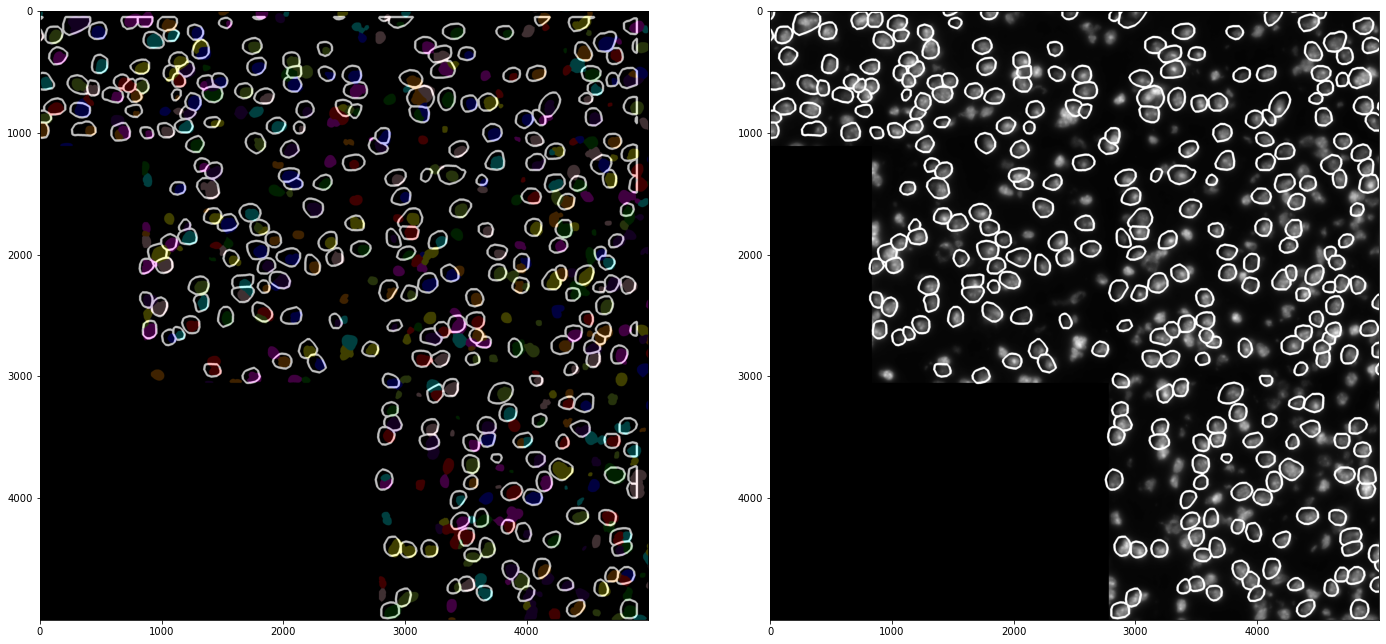

In [93]:
dx=50
dy=-100
gt_shifted = numpy.roll(numpy.roll(gt_img, dx, axis=0), dy, axis=1)[-raw_img.shape[0]:,:raw_img.shape[1]]
skimage.io.imsave("manual_annotation_aligned.tif", gt_shifted, plugin=None, check_contrast=True)

fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(skimage.color.label2rgb(oleh_img[-5000:,5000:10000],
                                    contours_from_labels(bbb, 10),
                                    alpha=0.25,
                                    bg_label=0))
axes[1].imshow(add_contours(gt_shifted[-5000:,5000:10000], raw_img[-5000:,5000:10000]), cmap='gray')

In [92]:
print(gt_shifted.shape)

(21505, 21505)


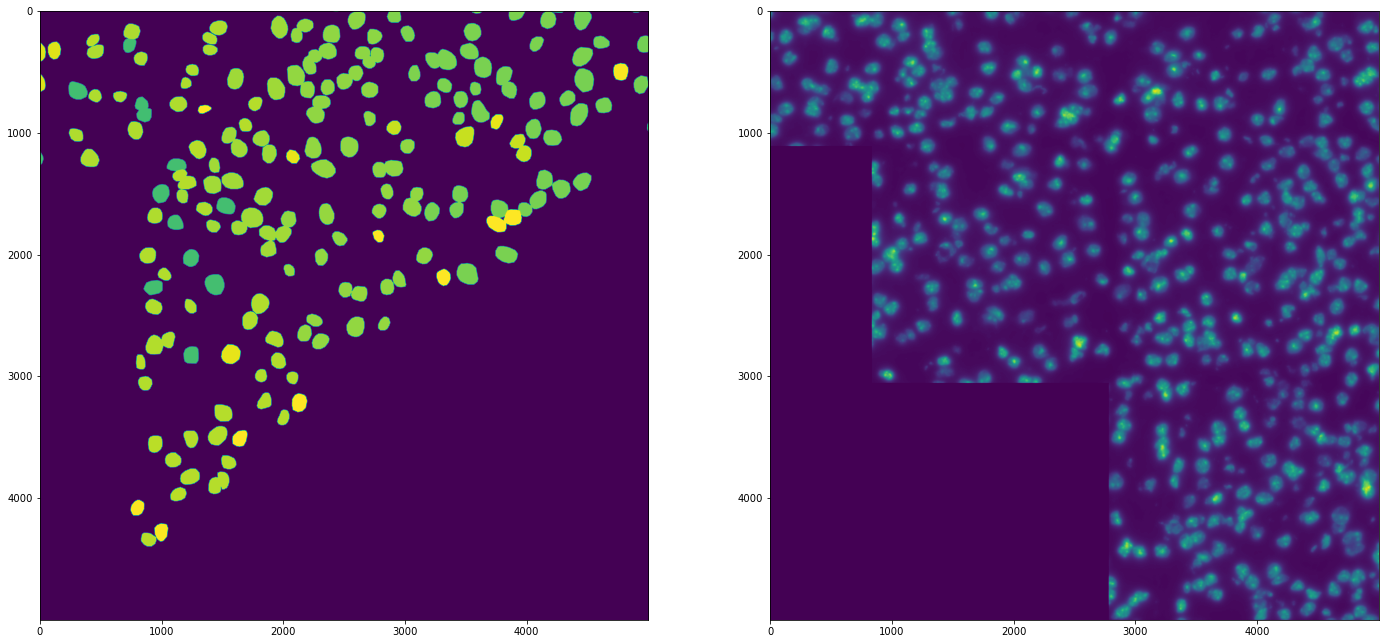

In [69]:
gt_shifted = numpy.roll(numpy.roll(gt_img, dx, axis=0), dy, axis=1)[:raw_img.shape[0],:raw_img.shape[0]]

fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(gt_shifted[-5000:,5000:10000])
axes[1].imshow(raw_img[-5000:,5000:10000])

In [ ]:
raw_small = skimage.transform.rescale(raw_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
gt_small = skimage.transform.rescale(gt_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
oleh_small = skimage.transform.rescale(oleh_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)

luca_small = luca_img

print(gt_small.shape)
print(raw_small.shape)
print(luca_img.shape)
print(oleh_small.shape)

In [ ]:
print(gt_small.T.shape)
print(raw_small.shape)
print(luca_small.shape)
print(oleh_small.shape)

fig, axes = plt.subplots(ncols=4, figsize=(24,24))
axes[0].imshow(gt_small.T)
axes[1].imshow(raw_small)
axes[2].imshow(luca_img)
axes[3].imshow(oleh_small)

In [ ]:
dx = gt_small.T.shape[0] - raw_small.shape[0]
dy = gt_small.T.shape[1] - raw_small.shape[1]
print(dx,dy)

gt_v1 = gt_small.T[dx:,dy:]
gt_v2 = gt_small.T[dx:,:raw_small.shape[1]]

In [ ]:
dx=-240
dy=-10
aaa = numpy.roll(numpy.roll(gt_small.T, dx, axis=0), dy, axis=1)[:oleh_small.shape[0],:oleh_small.shape[1]]

dx=-241
dy=-10
bbb = numpy.roll(numpy.roll(gt_small.T, dx, axis=0), dy, axis=1)[:oleh_small.shape[0],:oleh_small.shape[1]]

def add_contours(labels, img):
    c = contours_from_labels(labels, thickness=1)
    return add_red_contours(img, c)

fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(add_contours(aaa,raw_small)[2200:,700:1500])
axes[1].imshow(add_contours(bbb,raw_small)[2200:,700:1500])

In [ ]:
c1 = contours_from_labels(gt_v1, thickness=1)
c2 = contours_from_labels(gt_v2, thickness=1)
c3 = contours_from_labels(gt_v3, thickness=1)

check1  = add_red_contours(oleh_small, c1)
check2  = add_red_contours(oleh_small, c2)
check3  = add_red_contours(oleh_small, c3)

fig, axes = plt.subplots(ncols=3, figsize=(24,24))
axes[0].imshow(check1[2200:,700:1000])
axes[1].imshow(check2[2200:,700:1000])
axes[2].imshow(check3[2200:,700:1000])

In [ ]:

check1  = add_red_contours(raw_small, c1)
check2  = add_red_contours(luca_img, c1)

In [ ]:
fig, axes = plt.subplots(figsize=(24,24))
axes.imshow(check2)

In [ ]:
from skimage.morphology import convex_hull_image
gt_tmp = convex_hull_image(gt_small>0)
raw_tmp = convex_hull_image(raw_small>0)
luca_tmp = convex_hull_image(luca_img>0)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(skimage.color.label2rgb(gt_tmp,
                                       gt_small,
                                       alpha=1.0,
                                       bg_label=0))
axes[1].imshow(skimage.color.label2rgb(gt_small,
                                       gt_tmp,
                                       alpha=1.0,
                                       bg_label=0))

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(skimage.color.label2rgb(gt_tmp,
                                       gt_small,
                                       alpha=1.0,
                                       bg_label=0))
axes[1].imshow(skimage.color.label2rgb(gt_small,
                                       gt_tmp,
                                       alpha=1.0,
                                       bg_label=0))

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize)
axes[0, 0].imshow(skimage.color.label2rgb(tiling.integer_mask[0, 0].cpu().numpy(),
                                          numpy.zeros_like(tiling.integer_mask[0, 0].cpu().numpy()),
                                          alpha=1.0,
                                          bg_label=0))
axes[0, 1].imshow(skimage.color.label2rgb(tiling.integer_mask[0, 0].cpu().numpy(),
                                          tiling.raw_image[0, 0].cpu().numpy(),
                                          alpha=0.25,
                                          bg_label=0))

In [ ]:
plt.imshow(gt_small.T, cmap='gray')

In [ ]:
plt.imshow(raw_small)

In [ ]:
plt.imshow(gt_tmp)

In [ ]:
plt.imshow(gt_img.T)

In [ ]:
luca_labels_OLD = skimage.morphology.label(luca_img, background=0, return_num=False).astype(numpy.uint16)
oleh_labels = skimage.morphology.label(oleh_img, background=0, return_num=False).astype(numpy.uint16)

print(raw_img.shape, raw_img.dtype)
print(luca_img.shape, luca_labels_OLD.dtype)
print(oleh_img.shape, oleh_labels.dtype)

### Upsample luca's labels to match size of Oleh's labels 

In [ ]:
luca_labels = skimage.transform.resize(luca_labels_OLD, oleh_labels.shape,
                                       order=0, 
                                       clip=True, preserve_range=True).astype(numpy.uint16)
print(luca_labels.shape, luca_labels.dtype)

In [ ]:
# Compute the areas and check nothing went worng during upsampling
luca_cells_area_OLD = numpy.bincount(luca_labels_OLD.flatten())[1:]
luca_cells_area = numpy.bincount(luca_labels.flatten())[1:]
oleh_cells_area = numpy.bincount(oleh_labels.flatten())[1:]

plt.scatter(luca_cells_area,luca_cells_area_OLD)

### Save both segmentation with red contours 

In [ ]:
# make_and_save_segmentation(file_name="tmp.tiff", 
#                            labels=luca_labels[10000:11000,10000:11000], 
#                            raw_image=raw_img[10000:11000,10000:11000])

In [ ]:
# make_and_save_segmentation(file_name="luca_segmentation.tiff", 
#                            labels=luca_labels, 
#                            raw_image=raw_img)

In [ ]:
# make_and_save_segmentation(file_name="oleh_segmentation.tiff", 
#                            labels=oleh_labels, 
#                            raw_image=raw_img)

# Start the actual comparison

Based on:
1. luca_labels vs oleh_labels
2. luca_cells_area vs oleh_cells_area 

In [ ]:
ROI_mask = skimage.morphology.convex_hull_image(luca_labels > 0)
#plt.imshow(ROI_mask)

In [ ]:
window = make_list_of_windows(ROI_mask, n=4, crop_size=800)
plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(12,24))

In [ ]:
print("total segmented area: luca, oleh", luca_cells_area.sum(), oleh_cells_area.sum())

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel("cells area")
_ = ax.hist([luca_cells_area,oleh_cells_area], bins=50,label=["luca","oleh"])
_ = ax.legend()
fig.savefig("histo.png", dpi=300)

In [ ]:
float(luca_cells_area.shape[0]) / oleh_cells_area.shape[0]

In [ ]:
ratio_ol = float(oleh_cells_area.sum())/luca_cells_area.sum()
ratio_lo = float(luca_cells_area.sum())/oleh_cells_area.sum()
print(ratio_ol, ratio_lo)

In [ ]:
oleh_cells_area.sum()

In [ ]:
luca_cells_area.sum()

In [ ]:
window = [(8*1000, 8*2100, 8*1300, 8*2400)]
#window = [(8*1000, 8*2100, 8*1100, 8*2200)]

plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(24,24))

### Compute intersection over union

In [ ]:
import torch 
window = (8*1000, 8*2100, 8*1300, 8*2400)
window = (8*1000, 8*2100, 8*1100, 8*2200)
window = (0,0,luca_labels.shape[0],luca_labels.shape[1])

size = window[2]-window[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

luca_membership = torch.from_numpy(luca_labels[window[0]:window[2],window[1]:window[3]].astype(int)).flatten().to(device)
oleh_membership = torch.from_numpy(oleh_labels[window[0]:window[2],window[1]:window[3]].astype(int)).flatten().to(device)
luca_sizes = torch.bincount(luca_membership)
oleh_sizes = torch.bincount(oleh_membership)

In [ ]:
sizes, membership = Partition.compactify(luca_sizes, luca_membership)
luca_partition = Partition(which="luca",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

sizes, membership = Partition.compactify(oleh_sizes, oleh_membership)
oleh_partition = Partition(which="oleh",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

In [ ]:
plt.imshow(oleh_partition.membership.view(size,size))

In [ ]:
plt.imshow(luca_partition.membership.view(size,size))

In [ ]:
c = luca_partition.concordance_with_partition(oleh_partition) 

In [ ]:
c.iou

In [ ]:
plt.imshow(luca_partition.membership.view(size,size)==1)

In [ ]:
c

In [ ]:
torch.max(pxy)

In [ ]:
plt.matshow(pxy[1:,1:].T, cmap='gray')

In [ ]:
c_ol = oleh_partition.concordance_with_partition(luca_partition) 

In [ ]:
c_lo = luca_partition.concordance_with_partition(oleh_partition) 

In [ ]:
c_ol.iou

In [ ]:
c_lo.iou

In [ ]:
plt.imshow(oleh_partition.membership.view(size,size))

In [ ]:
plt.imshow(luca_partition.membership.view(size,size))